In [19]:
import numpy as np 
import pandas as pd
import time 
from tqdm import tqdm 
import requests

In [20]:
movies_genres = pd.read_csv("genre_data.csv")

In [21]:
movies_df = pd.DataFrame(movies_genres['movie_name'])

In [22]:
movies_df

,movie_name
0,The Beauty
1,Eamon
2,Earl Carroll Sketchbook
3,Art Idol
4,O Corpo Ardente
...,...
7995,Ying lie qian qiu
7996,Journey to Chazzabeh
7997,Nan zheng bei zhan
7998,Am Rande der Welt


In [23]:
tqdm.pandas()

In [24]:
API_KEY = '98649303'

def fetch_movie_metadata(title):
    """Fetches Year, Rated, and Language from OMDb API."""
    url = f"http://www.omdbapi.com/?t={title}&apikey={API_KEY}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        # OMDb returns 'Response': 'False' if the movie isn't found
        if data.get('Response') == 'True':
            # OMDb sometimes returns multiple languages ("Spanish, English"). We'll grab the first one.
            lang = data.get('Language', 'Unknown').split(',')[0].strip()
            
            return pd.Series({
                'year': data.get('Year', 'Unknown'),
                'rating': data.get('Rated', 'Unknown'),
                'language': lang
            })
        else:
            return pd.Series({'year': 'Unknown', 'rating': 'Unknown', 'language': 'Unknown'})
            
    except Exception as e:
        print(f"Error fetching {title}: {e}")
        return pd.Series({'year': 'Unknown', 'rating': 'Unknown', 'language': 'Unknown'})
        
    finally:
        # Be polite to the API so you don't get blocked
        time.sleep(0.05)
        
# --- EXECUTE API CALLS ---
print("Fetching movie data from OMDb...")
# progress_apply gives you a nice loading bar for your 8000 rows!
movies_df[['year', 'rating', 'language']] = movies_df['movie_name'].progress_apply(fetch_movie_metadata)


# --- PROCESS & CATEGORIZE DATA ---

# Clean the Year column (OMDb sometimes returns ranges like "2005-2010" for series, or has bad data)
# We coerce errors to NaN, then fill with 0, so we can do math on them.
movies_df['year_clean'] = pd.to_numeric(movies_df['year'].str[:4], errors='coerce').fillna(0).astype(int)

# Map Ratings to Broad Categories
rating_map = {
    'G': 'Family', 'PG': 'Family', 
    'PG-13': 'Teen', '12A': 'Teen',
    'R': 'Mature', 'NC-17': 'Mature', 'TV-MA': 'Mature',
    'Not Rated': 'Unknown', 'Unrated': 'Unknown', 'N/A': 'Unknown'
}
movies_df['content_category'] = movies_df['rating'].map(rating_map).fillna('Unknown')

# Calculate the Decade
movies_df['decade'] = (movies_df['year_clean'] // 10) * 10

# Create the Labels
movies_df['label_lang_rating'] = movies_df['language'] + " - " + movies_df['content_category']

# For the 3-part label, let's only append the decade if we actually found a valid year
def create_complex_label(row):
    base_label = f"{row['language']} - {row['content_category']}"
    if row['decade'] > 0:
        return f"{base_label} - {row['decade']}s"
    return f"{base_label} - Unknown Decade"

movies_df['label_lang_rating_decade'] = movies_df.apply(create_complex_label, axis=1)

# Final Cleanup (dropping the temporary clean year column)
final_df = movies_df[[
    'movie_name', 'rating', 'language', 'year', 
    'label_lang_rating', 'label_lang_rating_decade'
]]

print("\nFinal Dataset:")
print(final_df.to_string())

Fetching movie data from OMDb...


100%|███████████████████| 8000/8000 [24:20<00:00,  5.48it/s]



Final Dataset:
                                                                                  movie_name     rating        language       year         label_lang_rating            label_lang_rating_decade
0                                                                                 The Beauty      TV-MA         English      2026–          English - Mature            English - Mature - 2020s
1                                                                                      Eamon        N/A         English       2009         English - Unknown           English - Unknown - 2000s
2                                                                    Earl Carroll Sketchbook   Approved         English       1946         English - Unknown           English - Unknown - 1940s
3                                                                                   Art Idol        N/A            Thai       2012            Thai - Unknown              Thai - Unknown - 2010s
4                  

In [37]:
final_df['label_lang_rating_decade'].describe()

count                         8000
unique                         480
top       English - Mature - 2010s
freq                           759
Name: label_lang_rating_decade, dtype: object

In [38]:
final_df['label_lang_rating'].describe()

count                 8000
unique                 144
top       English - Mature
freq                  2276
Name: label_lang_rating, dtype: object

<AxesSubplot:>

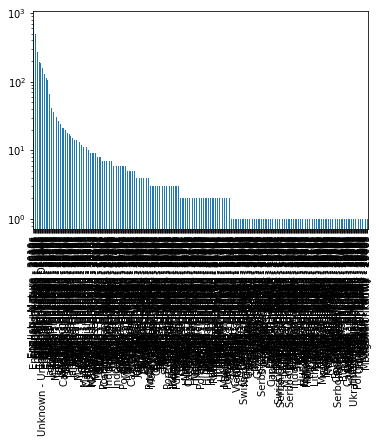

In [41]:
final_df['label_lang_rating_decade'].value_counts().plot(kind='bar',logy=True)

<AxesSubplot:>

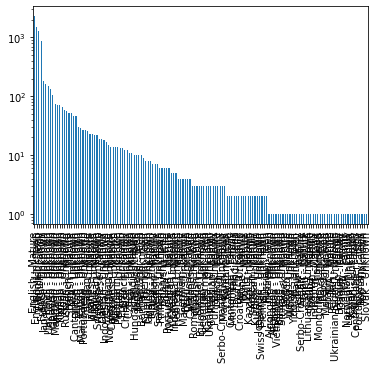

In [42]:
final_df['label_lang_rating'].value_counts().plot(kind='bar',logy=True)

In [44]:
final_df.to_csv('OutputTAKE4.csv', index=False)